# Visual Feature for Image Retrieval


In [1]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import os
import glob
import pickle
from IPython.display import HTML, display

from feature_extraction.color_histogram import color_histogram
from feature_extraction.grid_color_moment import grid_color_moment
from feature_extraction.gabor_texture import gabor_texture, genGaborFilters
from feature_extraction.local_descriptors import localDescriptor, VLAD, genCodeBook

In [2]:
# parameters
NUM_OF_CATEGORY = 35
NUM_OF_RELEVANT = 20

# categories
categories = [c.split('/')[1] for c in glob.glob('data/*')]
categories.sort()

def getCategory(index):
    return categories[index // NUM_OF_RELEVANT]

def getFilename(index):
    category = getCategory(index)
    return category, os.path.join('data', category, category + '_' + str(index % NUM_OF_RELEVANT + 1) + '.jpg')

## Feature Extraction
### Color Similarity
- Grid color moments: 
    
    Slice image into grids, and compute 1st, 2nd, and 3rd moments for each grid in each color channel (RGB color space). 
    <br> The feature is flatten as 225 dimension.

### Texture/Shape Similarity
- Gabor texture:
    
    The Gabor kernel is generated from the OpenCV library. However, the parameters for generating Gabor wavelet ($\sigma$, $\gamma$, and $\lambda$) is compute by myself according to [2]. 
    <br> For the aspect ratio $\gamma$, I found the result calculated from the formula (for computing $\sigma_\nu$) in the original paper [1] is weird (hope it is not because I implemented it wrong.) Therefore, I derived it by myself and the result seems right.
    <br> For the visualization of the Gabor filters, please see the appendix.
    
    The image are first convert to grayscale and convoluted with the Gabor filters. Then, the mean and standard deviation of the results are computed over each grid (similar to grid color moments.)

    Reference:
    - [1] Texture features for browsing and retrieval of image data, https://ieeexplore.ieee.org/document/531803
    - [2] Gabor濾波器詳解, https://www.itread01.com/content/1546890854.html
    

### Local Feature Similarity
- Local Feature Mapping:
    
    
    
- VLAD:

    Reference:
    - [1] OpenCV ORB (Oriented FAST and Rotated BRIEF), https://docs.opencv.org/4.4.0/d1/d89/tutorial_py_orb.html
    - [2] OpenCV Feature Matching, https://docs.opencv.org/master/dc/dc3/tutorial_py_matcher.html
    - [3] Python implementation of VLAD for a CBIR system, https://github.com/jorjasso/VLAD
    - [4] Caltech 101 dataset, http://www.vision.caltech.edu/Image_Datasets/Caltech101/

In [3]:
# Feature extraction
def extract_feature(name, method, cs='RGB', path='features/', overwrite=False, **kwargs):
    
    # load from files
    filepath = os.path.join(path, name + '.npy')
    if not overwrite and os.path.isfile(filepath):
        print('load pre-generated features from file')
        return np.load(filepath, allow_pickle=True)
    
    features = []
    for category in categories:
        for i in range(1, 21):

            # read image
            filename = os.path.join('data', category, category + '_' + str(i) + '.jpg')
            
            # color space
            img = cv2.imread(filename)
            if cs == 'RGB':
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            elif cs == 'HSV':
                img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
            elif cs == 'YCrCb':
                img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
            elif cs == 'GRAY':
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            
            # extract feature
            feature = method(img, **kwargs)

            # store feature
            features.append(feature)
            
    # save features into file
    features = np.array(features)
    np.save(filepath, features)
    
    return features
    

In [4]:
# Grid Color Moment
def genGCM(cs, grids, ow=False):
    # filename
    name = 'gcm_g{}_{}'.format(grids, cs)

    # extract features
    feature = extract_feature(name, grid_color_moment, overwrite=ow, cs=cs, gx=grids, gy=grids)
    # shape: (grids)^2 * color_channel * 3(mean & std & skewness)
    
    return name, feature

# Color Histogram
def genCH(cs, grids, n_bin, ow=False):
    # filename
    name = 'ch_g{}_{}_({})'.format(grids, cs, '_'.join(str(x) for x in n_bin))

    # extract features
    feature = extract_feature(name, color_histogram, overwrite=ow, cs=cs, gx=grids, gy=grids, n_bin=n_bin)
    # shape: (grids)^2 * n_bin
    return name, feature


# Gabor Texture
def genGabor(cs, grids, K, S, ow=False):
    name = 'gabor_g{}_k{}_s{}_{}'.format(grids, K, S, cs)

    # extract features
    gabor_filters = genGaborFilters(K=K, S=S)
    feature = extract_feature(name, gabor_texture, overwrite=ow, cs=cs, filters=gabor_filters, gx=grids, gy=grids)
    # shape: K * S * (grids)^2 * 2(mean & std)
    return name, feature

# Local Descriptors in various numbers of grids
def genLD(cs, grids, det='SIFT', ow=False):
    '''
        grids: needs to be power of 2
    '''
    name = '{}_g{}_{}'.format(det, grids, cs)
    
    # detector
    if det == 'ORB':
        detector = cv2.ORB_create()
    else:
        detector = cv2.SIFT_create()

    # compute SIFT descriptor
    feature = extract_feature(name, localDescriptor, overwrite=ow, cs=cs, detector=detector, g=grids)
    
    # shape: (grids)^2 * n descriptor * d component
    return name, feature

# VLAD
def genVLAD(k, des, des_name, codebook, grids, ow=False):
    # parameters
    name = 'k{}_{}'.format(k, des_name)

    # compute VLAD descriptor
    feature_vlad, feature_hist = VLAD(name, des, k, codebook, grids, overwrite=ow)
    # (grids)^2 * k class * d components 
    return 'vlad_'+name, feature_vlad, 'hist_'+name, feature_hist

In [ ]:
# Pre-generate -- Grid Color Moment
for cs in ['RGB', 'HSV', 'YCrCb']:
    for grids in range(1, 10):
        name_gcm, feature_gcm = genGCM(cs, grids)
        print(name_gcm, feature_gcm.shape)

In [ ]:
# Pre-generate -- Color Histogram
for cs, n_bin in zip(['RGB', 'HSV'], [[4, 4, 4], [18, 3, 3]]):
    for grids in range(1, 10):
        name_ch, feature_ch = genCH(cs, grids, n_bin)
        
        print(name_ch, feature_ch.shape)

In [ ]:
# Pre-generate -- Gabor Texture
for cs in ['GRAY', 'RGB', 'HSV']:
    for K, S in [[6, 8], [8, 6], [12, 8]]:
        for grids in range(1, 10):
            name_gabor, feature_gabor = genGabor(cs, grids, K, S)

            print(name_gabor, feature_gabor.shape)

In [ ]:
# Pre-generate -- Local Descriptors
for det in ['SIFT', 'ORB']:
    for cs in ['RGB', 'GRAY']:
        for grids in [1, 2, 4, 8]:
            name_ld, feature_ld = genLD(cs, grids, det)
            
            print(name_ld, feature_ld.shape)
            if grids == 1:
                print(feature_ld[0].shape)
            else:
                print(np.shape(feature_ld[1, 0]))

In [ ]:
# Pre-generate -- VLAD
for db_folder in ['101_ObjectCategories', 'data']:
    for detector in ['SIFT', 'ORB']:
        for k in [16, 32, 64, 128]:
            # generate codebook
            codebook = genCodeBook(db_folder, k, detector)
            
            for grids in [1, 2, 4, 8]:
                # load local descriptor
                name_ld, feature_ld = genLD(cs='RGB', grids=grids, det=detector)

                # VLAD
                name_vlad, feature_vlad = genVLAD(k, feature_ld, name_ld, codebook, grids)
                print(name_vlad, feature_vlad)

In [5]:
# delete loaded features to release memory
# del feature_gcm
# del feature_gabor
# del feature_sift
# del feature_orb
# del feature_vlad

## Evaluations

In [5]:
# Ranking
def ranking(name, features, dist_func, ascend=True, symmetric=True, path='results/', overwrite=False, **kargs):
    '''
        ascend: ranking in ascending (for distance) or descending order (for similarity)
        symmetric: if the distance function has commutative property, the process can be speedup
    '''
    # load from files
    rank_filepath = os.path.join(path, 'ranking', name + '.npy')
    dist_filepath = os.path.join(path, 'dist', name + '.npy')
    if not overwrite and os.path.isfile(rank_filepath) and os.path.isfile(dist_filepath):
        print('load pre-computed results from file')
        return np.load(rank_filepath, allow_pickle=True), np.load(dist_filepath, allow_pickle=True)
    
    # distance/similarity
    n_feature = len(features)
    dist = []
    if symmetric:
        for i in range(n_feature):
            dist_row = []
            # reduce reduntant computation
            for j in range(i):
                dist_row.append(dist[j][i])
            # computer features
            for j in range(i, n_feature):
                dist_row.append(dist_func(features[i], features[j], **kargs))
            
            dist.append(dist_row)
    else:
        for i in range(n_feature):
            dist_row = []
            # computer features
            for j in range(n_feature):
                dist_row.append(dist_func(features[i], features[j], **kargs))
            
            dist.append(dist_row)
    
    # ranking (including the target image itself)
    ranked_all = np.argsort(dist, axis=1)
    if not ascend:
        # reverse for descending order
        ranked_all = ranked_all[:, ::-1]
    
    # baseline check: the first retrived image should be the target image itself
    ranked = []
    for i in range(len(ranked_all)):
        target_rank = 0
        if ranked_all[i, 0] != i:
            target_rank = np.where(ranked_all[i] == i)
            print('Baseline check Failed: ', i, ranked_all[i, 0], target_rank)
            
        # remove the target image from the result
        ranked.append(np.delete(ranked_all[i], target_rank))
        
    # save features into file
    ranked = np.array(ranked)
    dist = np.array(dist)
    np.save(rank_filepath, ranked)
    np.save(dist_filepath, dist)
    
    return np.array(ranked), dist

# distance/similarity function
def Ln_distance(a, b, ord=1, weight=None):
    if weight is not None:
        # weighting over each feature
        return np.linalg.norm((a-b)*weight, ord=ord)
    else:
        return np.linalg.norm(a-b, ord=ord)

# local feature matching function
def matching(query_des, train_des, match_func, grids=1, rt=None):
    '''
        k: find best k match of each query descriptor
    '''
    if grids == 1:
        query_des = [query_des]
        train_des = [train_des]
    
    # run over each grid
    counts = 0
    for des_q, des_t in zip(query_des, train_des):
        # skip empty grids
        if len(des_q) == 0 or len(des_t) == 0:
            continue
        
        # matching
        if rt is None:
            matches = match_func(np.array(des_q), np.array(des_t))
            counts += len(matches)
        else:
            # knn & ratio test
            matches = match_func(np.array(des_q), np.array(des_t), k=2)
            
            good_match = 0
            for m in matches:
                if len(m) > 1 and m[0].distance < rt * m[1].distance:
                    # if the distance of best match is much smaller than the second
                    # then it is a good match
                    good_match += 1
                    
            counts += good_match
    
    return counts
    

In [6]:
def computeMAP(ranking):
    # precisiion & recall
    P = []
    R = []
    
    # AP of each image
    APs = []
    
    for i in range(len(ranking)):
        
        tp = 0 # true positive
        fp = 0 # false positive 

        precision = []
        recall = []
        AP = []
        
        cur_category = i // NUM_OF_RELEVANT
        
        for j in range(len(ranking[i])):
            if ranking[i, j] // NUM_OF_RELEVANT == cur_category:
                # matched
                tp += 1
                precision.append(tp / (tp + fp))
                recall.append(tp / NUM_OF_RELEVANT)
                # add precision in to the list
                AP.append(precision[-1])
            else:
                # mismatched
                fp += 1
                precision.append(tp / (tp + fp))
                recall.append(tp / NUM_OF_RELEVANT)
                
        AP = np.mean(AP)
        APs.append(AP)
        P.append(precision)
        R.append(recall)
        
    MMAP = np.mean(APs)
    MAP = [np.mean(APs[i*NUM_OF_RELEVANT:(i+1)*NUM_OF_RELEVANT]) for i in range(NUM_OF_CATEGORY)]
    P = np.mean(P, axis=0)
    R = np.mean(R, axis=0)
    
    return MMAP, MAP, P, R
                
            

In [7]:
# Ln distance
def evalLn(fname, feature, ord, weight=None, ow=False):
    # filename
    name = fname + '_L{}'.format(ord)
    
    # ranking
    ranked, _ = ranking(name, feature, Ln_distance, overwrite=ow, ord=ord, weight=weight)
    # MAP
    MMAP, MAP, P, R = computeMAP(ranked)
    
    return name, {'MMAP': MMAP, 'MAP': MAP, 'P': P, 'R': R}

# def evalMatch(fname, feature, match_func, ord, ow=False):
#     # filename
#     name = fname + 'L{}'.format(ord)
    
#     ranked, dist = ranking(feature_sift, matching, ascend=False, symmetric=False, match_func=match_func)

In [8]:
# Evaluations
results = {}

In [9]:
# Grid Color Moment
for cs in ['RGB', 'HSV', 'YCrCb']:
    for grids in range(1, 10):
        # generate (or load) features
        name_gcm, feature_gcm = genGCM(cs, grids)
        print(name_gcm, feature_gcm.shape)
        
        # evaluation (or load result)
        for order in [1, 2]:
            name, result = evalLn(name_gcm, feature_gcm, ord=order)
            results[name] = result

load pre-generated features from file
gcm_g1_RGB (700, 9)
load pre-computed results from file
load pre-computed results from file
load pre-generated features from file
gcm_g2_RGB (700, 36)
load pre-computed results from file
load pre-computed results from file
load pre-generated features from file
gcm_g3_RGB (700, 81)
load pre-computed results from file
load pre-computed results from file
load pre-generated features from file
gcm_g4_RGB (700, 144)
load pre-computed results from file
load pre-computed results from file
load pre-generated features from file
gcm_g5_RGB (700, 225)
load pre-computed results from file
load pre-computed results from file
load pre-generated features from file
gcm_g6_RGB (700, 324)
load pre-computed results from file
load pre-computed results from file
load pre-generated features from file
gcm_g7_RGB (700, 441)
load pre-computed results from file
load pre-computed results from file
load pre-generated features from file
gcm_g8_RGB (700, 576)
load pre-computed re

In [10]:
# Color Histogram
for cs, n_bin in zip(['RGB', 'HSV'], [[4, 4, 4], [18, 3, 3]]):
    for grids in range(1, 10):
        # generate (or load) features
        name_ch, feature_ch = genCH(cs, grids, n_bin)
        print(name_ch, feature_ch.shape)
        
        # evaluation (or load result)
        for order in [1, 2]:
            name, result = evalLn(name_ch, feature_ch, ord=order)
            results[name] = result
        

load pre-generated features from file
ch_g1_RGB_(4_4_4) (700, 64)
load pre-computed results from file
load pre-computed results from file
load pre-generated features from file
ch_g2_RGB_(4_4_4) (700, 256)
load pre-computed results from file
load pre-computed results from file
load pre-generated features from file
ch_g3_RGB_(4_4_4) (700, 576)
load pre-computed results from file
load pre-computed results from file
load pre-generated features from file
ch_g4_RGB_(4_4_4) (700, 1024)
load pre-computed results from file
load pre-computed results from file
load pre-generated features from file
ch_g5_RGB_(4_4_4) (700, 1600)
load pre-computed results from file
load pre-computed results from file
load pre-generated features from file
ch_g6_RGB_(4_4_4) (700, 2304)
load pre-computed results from file
load pre-computed results from file
load pre-generated features from file
ch_g7_RGB_(4_4_4) (700, 3136)
load pre-computed results from file
load pre-computed results from file
load pre-generated featu

In [ ]:
# Gabor Texture
for cs in ['GRAY', 'RGB', 'HSV']:
    for K, S in [[6, 8], [8, 6], [12, 8]]:
        for grids in range(1, 10):
            # generate (or load) features
            name_gabor, feature_gabor = genGabor(cs, grids, K, S)
            print(name_gabor, feature_gabor.shape)

            # evaluation (or load result)
            for order in [1, 2]:
                weight = 1/np.std(feature_gabor, axis=0)
                name, result = evalLn(name_gabor, feature_gabor, ord=order, weight=weight)
                results[name] = result

In [11]:
# SIFT
det = 'SIFT'
matcher = cv2.BFMatcher()
for cs in ['RGB', 'GRAY']:
    for grids in [1, 2, 4, 8]:
        # generate (or load) features
        name_ld, feature_ld = genLD(cs, grids, det)
        print(name_ld, feature_ld.shape)

        # evaluation (or load result)
        ranked, _ = ranking(name_ld, feature_ld, matching, ascend=False, symmetric=False, overwrite=False, match_func=matcher.knnMatch, grids=grids, rt=0.7)
        # MAP
        MMAP, MAP, P, R = computeMAP(ranked)

        results[name_ld] = {'MMAP': MMAP, 'MAP': MAP, 'P': P, 'R': R}
            

load pre-generated features from file
SIFT_g1_RGB (700,)
load pre-computed results from file
load pre-generated features from file
SIFT_g2_RGB (700, 4)
load pre-computed results from file
load pre-generated features from file
SIFT_g4_RGB (700, 16)
load pre-computed results from file
load pre-generated features from file
SIFT_g8_RGB (700, 64)
load pre-computed results from file
load pre-generated features from file
SIFT_g1_GRAY (700,)
load pre-computed results from file
load pre-generated features from file
SIFT_g2_GRAY (700, 4)
load pre-computed results from file
load pre-generated features from file
SIFT_g4_GRAY (700, 16)
load pre-computed results from file
load pre-generated features from file
SIFT_g8_GRAY (700, 64)
load pre-computed results from file


In [12]:
# ORB
det = 'ORB'
matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
for cs in ['RGB', 'GRAY']:
    for grids in [1, 2, 4, 8]:
        # generate (or load) features
        name_ld, feature_ld = genLD(cs, grids, det)
        print(name_ld, feature_ld.shape)

        # evaluation (or load result)
        ranked, _ = ranking(name_ld, feature_ld, matching, ascend=False, symmetric=False, overwrite=False, match_func=matcher.match, grids=grids)
        # MAP
        MMAP, MAP, P, R = computeMAP(ranked)

        results[name_ld] = {'MMAP': MMAP, 'MAP': MAP, 'P': P, 'R': R}
            

load pre-generated features from file
ORB_g1_RGB (700,)
load pre-computed results from file
load pre-generated features from file
ORB_g2_RGB (700, 4)
load pre-computed results from file
load pre-generated features from file
ORB_g4_RGB (700, 16)
load pre-computed results from file
load pre-generated features from file
ORB_g8_RGB (700, 64)
load pre-computed results from file
load pre-generated features from file
ORB_g1_GRAY (700,)
load pre-computed results from file
load pre-generated features from file
ORB_g2_GRAY (700, 4)
load pre-computed results from file
load pre-generated features from file
ORB_g4_GRAY (700, 16)
load pre-computed results from file
load pre-generated features from file
ORB_g8_GRAY (700, 64)
load pre-computed results from file


In [ ]:
# VLAD & Histogram of Visual Word
for db_folder in ['101_ObjectCategories', 'data']:
    for detector in ['SIFT', 'ORB']:
        for k in [16, 32, 64, 128]:
            # generate (or load) codebook
            codebook = genCodeBook(db_folder, k, detector)
            
            for grids in [1, 2, 4, 8]:
                # generate (or load) local descriptor
                name_ld, feature_ld = genLD(cs='RGB', grids=grids, det=detector)

                # generate (or load) features
                name_vlad, feature_vlad, name_hist, feature_hist = genVLAD(k, feature_ld, name_ld, codebook, grids)
                print(name_vlad, feature_vlad.shape)
                print(name_hist, feature_hist.shape)
                
                # evaluation (or load result)
                for order in [1, 2]:
                    # vlad
                    name, result = evalLn(name_vlad, feature_vlad, ord=order)
                    results[name] = result
                    # hist
                    name, result = evalLn(name_hist, feature_hist, ord=order)
                    results[name] = result

In [14]:
# **Evaluations -- VLAD & Histogram of Visual Word
db_folder = '101_ObjectCategories'
detector = 'SIFT'
k = 16

# generate codebook
codebook = genCodeBook(db_folder, k, detector)

# VLAD
for grids in [1, 2, 4, 8]:
    # load local descriptor
    name_ld, feature_ld = genLD(cs='RGB', grids=grids, det=detector)
    
    name_vlad, feature_vlad, name_hist, feature_hist = genVLAD(k, feature_ld, name_ld, codebook, grids)
    print(name_vlad, feature_vlad.shape)
    print(name_hist, feature_hist.shape)

    # evaluation (or load result)
    for order in [1, 2]:
        # vlad
        name, result = evalLn(name_vlad, feature_vlad, ord=order)
        results[name] = result
        # hist
        name, result = evalLn(name_hist, feature_hist, ord=order)
        results[name] = result

load code book from file
load pre-generated features from file
load pre-computed features from file
vlad_k16_SIFT_g1_RGB (700, 2048)
hist_k16_SIFT_g1_RGB (700, 16)
load pre-computed results from file
load pre-computed results from file
load pre-computed results from file
load pre-computed results from file
load pre-generated features from file
load pre-computed features from file
vlad_k16_SIFT_g2_RGB (700, 8192)
hist_k16_SIFT_g2_RGB (700, 64)
load pre-computed results from file
load pre-computed results from file
load pre-computed results from file
load pre-computed results from file
load pre-generated features from file
load pre-computed features from file
vlad_k16_SIFT_g4_RGB (700, 32768)
hist_k16_SIFT_g4_RGB (700, 256)
load pre-computed results from file
load pre-computed results from file
load pre-computed results from file
load pre-computed results from file
load pre-generated features from file
load pre-computed features from file
vlad_k16_SIFT_g8_RGB (700, 131072)
hist_k16_SIFT_

KeyboardInterrupt: 

In [ ]:
# Fusion


# Visualization

In [ ]:
# Comparison between methods
def compareResult(results, order=None, prefix=None):
    
    table = """
    <table>
    <tr>
    <th>categories vs. methods</th>
    <th>MAP</th>
    <th>Best Two Categories (w/ MAP)</th>
    <th>Worst Two Categories (w/ MAP)</th>
    </tr>
    """
    
    # filter key
    if prefix is not None:
        results = {key: val for key, val in results.items() if key.startswith(prefix)}
    
    # sort key
    if order is None:
        # default: sort by method name
        sorted_key = sorted(results)
    else:
        # sort by value
        sorted_key = sorted(results, key=lambda x:results[x][order], reverse=True)
        
    # figure size
    org_fz = plt.rcParams['figure.figsize']
    org_dpi = plt.rcParams['figure.dpi']
    plt.rcParams['figure.figsize'] = [12, 8]
    plt.rcParams['figure.dpi'] = 100
        
    for key in sorted_key:
        MAP = results[key]['MAP']
        MAP_sort = np.argsort(MAP)
        # print(MAP_sort)

        table += """
        <tr>
        <td>{}</td>
        <td>{:.3f}</td>
        <td>{} ({:.3f}), {} ({:.3f})</td>
        <td>{} ({:.3f}), {} ({:.3f})</td>
        </tr>
        """.format(key, results[key]['MMAP'], categories[MAP_sort[-1]], MAP[MAP_sort[-1]], categories[MAP_sort[-2]], MAP[MAP_sort[-2]], categories[MAP_sort[0]], MAP[MAP_sort[0]], categories[MAP_sort[1]], MAP[MAP_sort[1]])

        # PR curve
        plt.plot(results[key]['R'], results[key]['P'], label=key)


    table += "</table>"
    display(HTML(table))

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc='upper right')
    plt.show()
    
    # reset figure size
    plt.rcParams['figure.figsize'] = org_fz
    plt.rcParams['figure.dpi'] = org_dpi

categories vs. methods,MAP,Best Two Categories (w/ MAP),Worst Two Categories (w/ MAP)
SIFT_g1_RGB,0.256,"gge_snack (1.000), korean_snack (1.000)","ice_cream (0.023), bicycle (0.028)"
ch_g3_HSV_(18_3_3)_L1,0.241,"sprite (0.491), korean_snack (0.486)","nba_jersey (0.039), sweeping_robot (0.045)"
gcm_g7_HSV_L1,0.215,"goggles (0.484), blue_pillow (0.439)","nba_jersey (0.047), sweeping_robot (0.072)"
ORB_g1_GRAY,0.170,"gge_snack (0.975), korean_snack (0.913)","blue_pillow (0.017), mouse (0.017)"


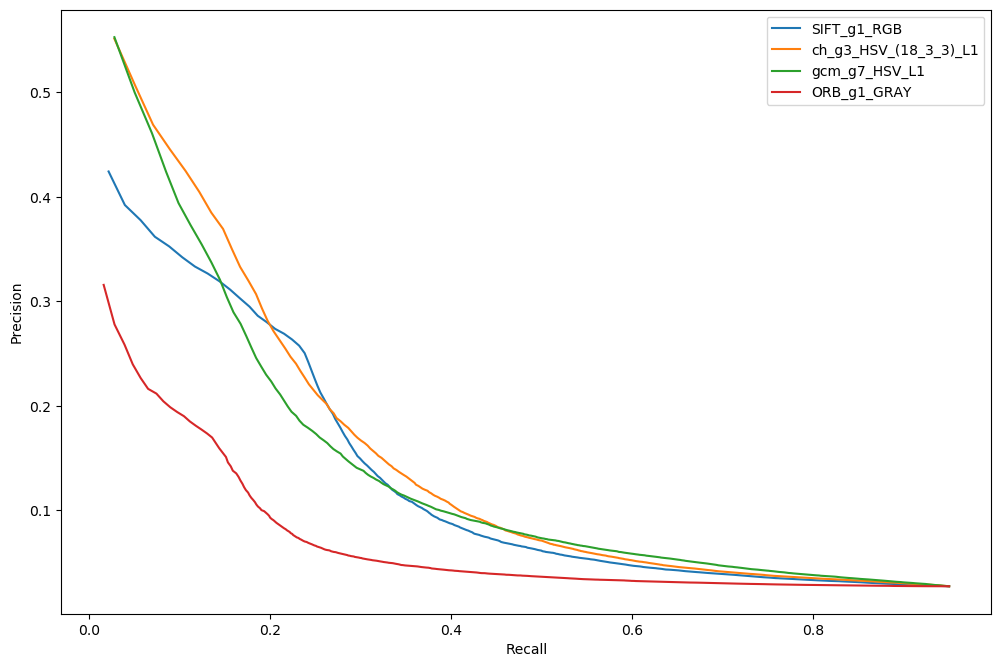

gcm_g7_HSV_L1


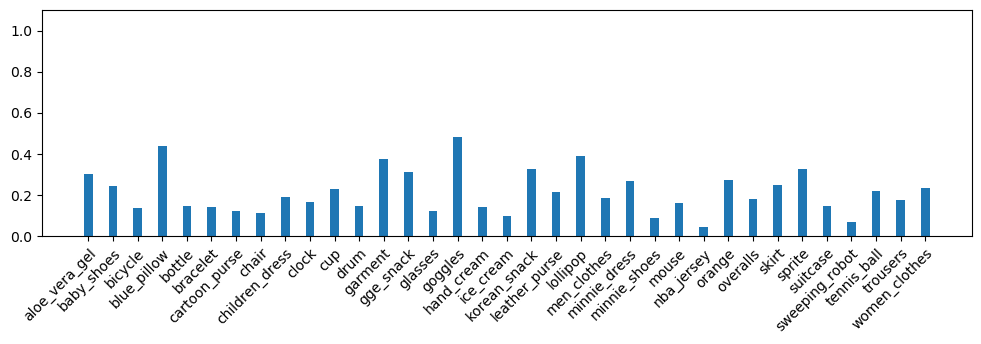

ch_g3_HSV_(18_3_3)_L1


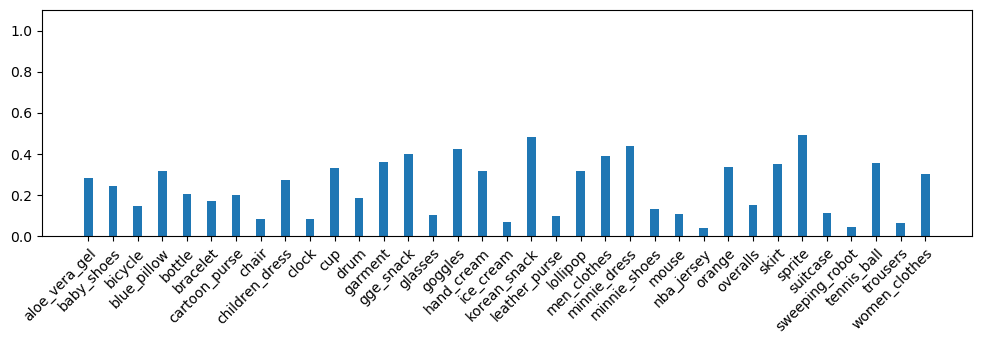

SIFT_g1_RGB


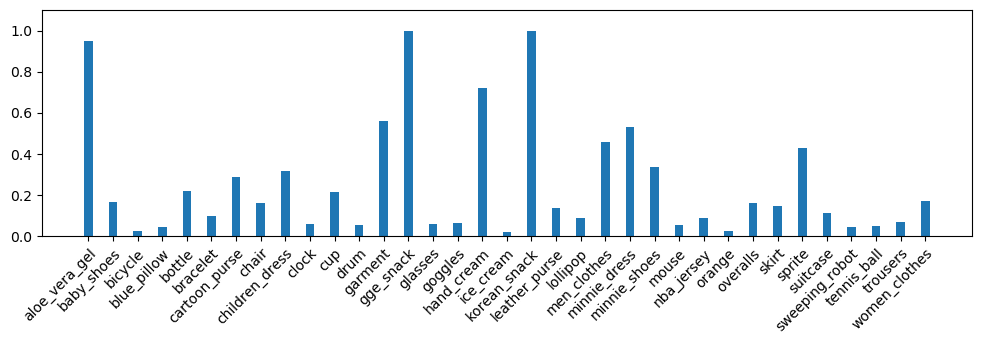

ORB_g1_GRAY


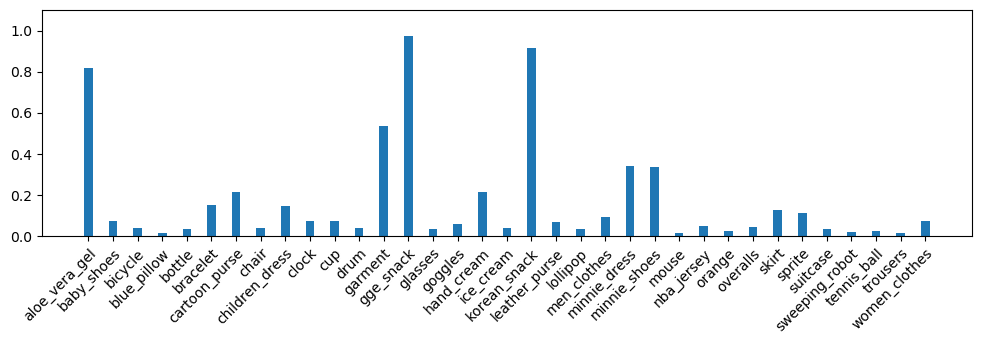

In [25]:
# Comparison between methods with configurations that produce the best results
best_methods = [
    'gcm_g7_HSV_L1', 
    'ch_g3_HSV_(18_3_3)_L1', 
    'SIFT_g1_RGB', 
    'ORB_g1_GRAY'
]
best_results = {key: results[key] for key in best_methods}

compareResult(best_results, order='MMAP')

# plot MAP
for key in best_methods:
    print(key)
    # figure size
    org_fz = plt.rcParams['figure.figsize']
    org_dpi = plt.rcParams['figure.dpi']
    plt.rcParams['figure.figsize'] = [12, 3]
    plt.rcParams['figure.dpi'] = 100
    
    fig, ax = plt.subplots()

    ax.bar(np.arange(35), results[key]['MAP'], 0.35)
    ax.set_ylim([0, 1.1])
    ax.set_xticks(np.arange(35))
    ax.set_xticklabels(categories)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    plt.show()
    
    # reset figure size
    plt.rcParams['figure.figsize'] = org_fz
    plt.rcParams['figure.dpi'] = org_dpi

In [ ]:
# Comparison -- Grid Color Moments
compareResult(results, order='MMAP', prefix='gcm')

In [ ]:
# Comparison -- Color Histogram
compareResult(results, order='MMAP', prefix='ch')

In [ ]:
# Comparison -- Gabor Texture
compareResult(results, order='MMAP', prefix='gabor')

In [ ]:
# Comparison -- SIFT
compareResult(results, order='MMAP', prefix='SIFT')

In [ ]:
# Comparison -- ORB
compareResult(results, order='MMAP', prefix='ORB')

In [ ]:
# Comparison -- Histogram of Visual Words
compareResult(results, order='MMAP', prefix='hist')

In [ ]:
# Comparison -- VLAD
compareResult(results, order='MMAP', prefix='vlad')

In [27]:
for i, cate in enumerate(categories):
    print(i, cate)

0 aloe_vera_gel
1 baby_shoes
2 bicycle
3 blue_pillow
4 bottle
5 bracelet
6 cartoon_purse
7 chair
8 children_dress
9 clock
10 cup
11 drum
12 garment
13 gge_snack
14 glasses
15 goggles
16 hand_cream
17 ice_cream
18 korean_snack
19 leather_purse
20 lollipop
21 men_clothes
22 minnie_dress
23 minnie_shoes
24 mouse
25 nba_jersey
26 orange
27 overalls
28 skirt
29 sprite
30 suitcase
31 sweeping_robot
32 tennis_ball
33 trousers
34 women_clothes


Target Image: data/bicycle/bicycle_1.jpg


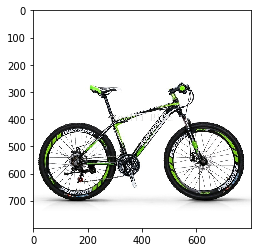

Result Images 0: data/bicycle/bicycle_1.jpg
Result Images 1: data/lollipop/lollipop_8.jpg
Result Images 2: data/trousers/trousers_14.jpg
Result Images 3: data/mouse/mouse_4.jpg
Result Images 4: data/lollipop/lollipop_16.jpg
Result Images 5: data/suitcase/suitcase_14.jpg
Result Images 6: data/drum/drum_3.jpg
Result Images 7: data/clock/clock_4.jpg
Result Images 8: data/overalls/overalls_16.jpg
Result Images 9: data/sprite/sprite_7.jpg
Result Images 10: data/minnie_dress/minnie_dress_1.jpg
Result Images 11: data/tennis_ball/tennis_ball_4.jpg
Result Images 12: data/drum/drum_11.jpg
Result Images 13: data/cup/cup_8.jpg
Result Images 14: data/bottle/bottle_7.jpg
Result Images 15: data/mouse/mouse_9.jpg
Result Images 16: data/lollipop/lollipop_6.jpg
Result Images 17: data/sweeping_robot/sweeping_robot_4.jpg
Result Images 18: data/mouse/mouse_3.jpg


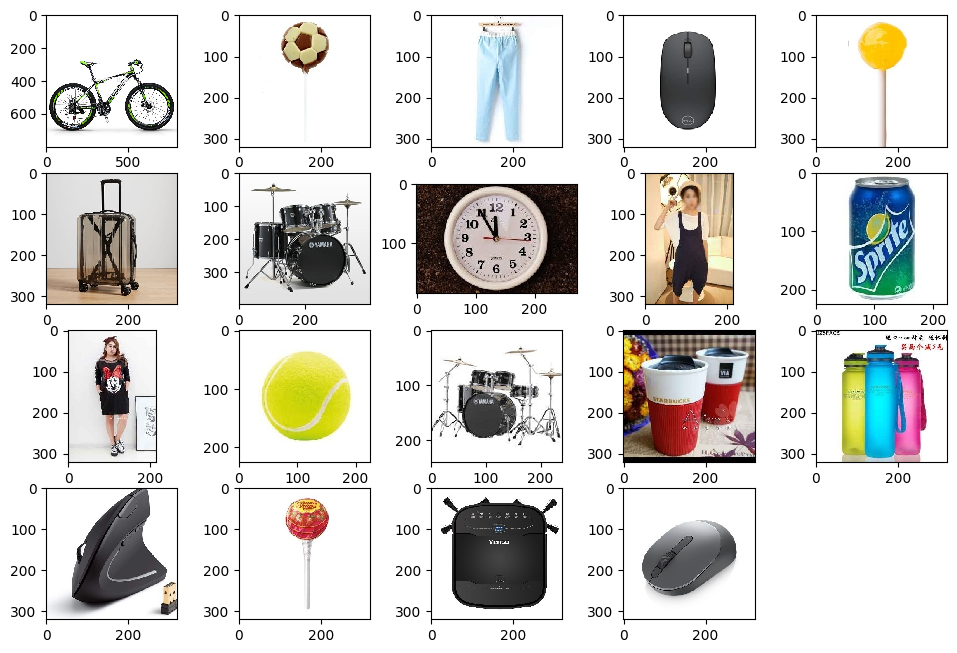

In [76]:
# Visualization
# target image
target_idx = 2*20
cat, filename = getFilename(target_idx)
print('Target Image:', filename)
plt.imshow(Image.open(filename))
plt.show()

# figure size
org_fz = plt.rcParams['figure.figsize']
org_dpi = plt.rcParams['figure.dpi']
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

# queried images
for i in range(19):
    result_idx = ranked[target_idx, i]
    cat, filename = getFilename(result_idx)
    print('Result Images {}: {}'.format(i, filename))
    plt.subplot(4, 5, i+1)
    plt.imshow(Image.open(filename))
plt.show()

# reset figure size
plt.rcParams['figure.figsize'] = org_fz
plt.rcParams['figure.dpi'] = org_dpi

# Appendix


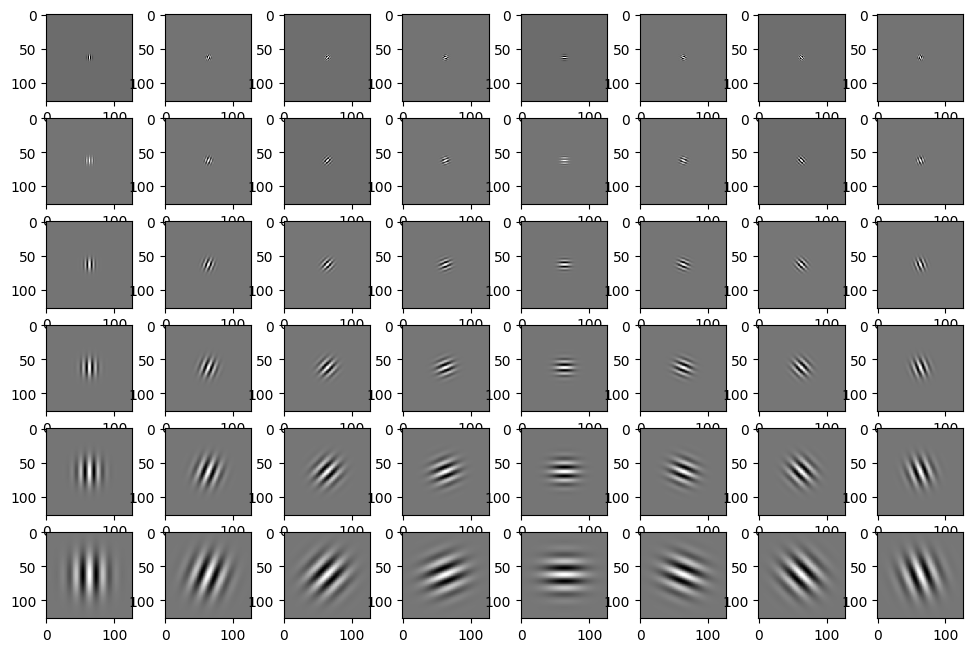

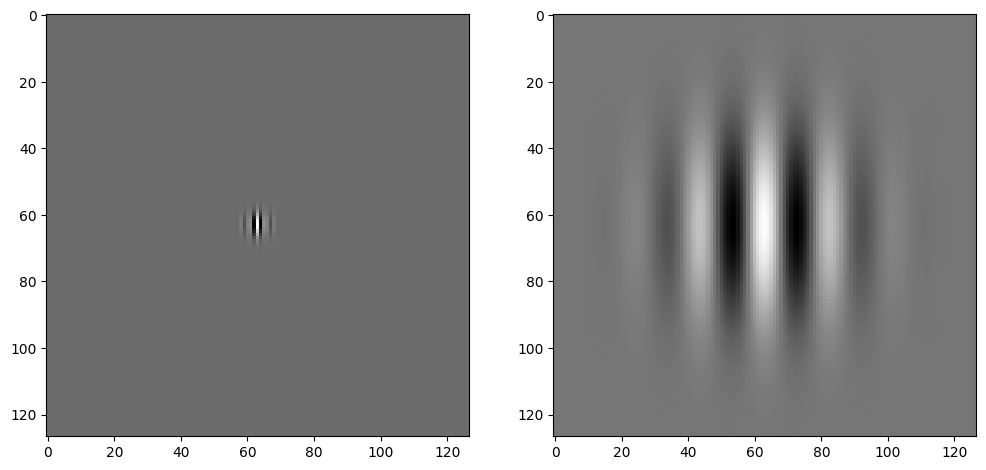

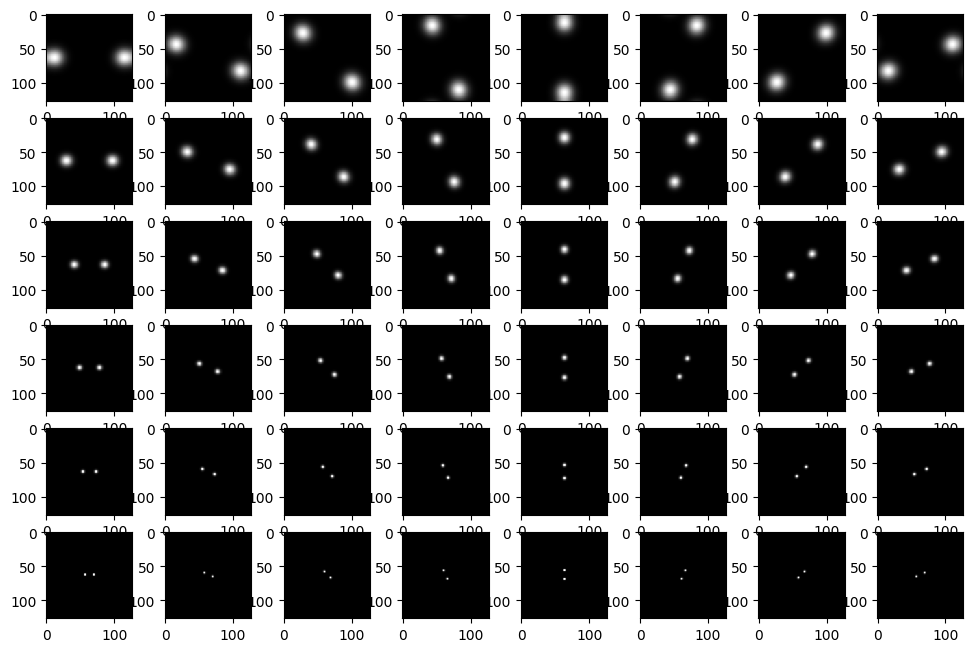

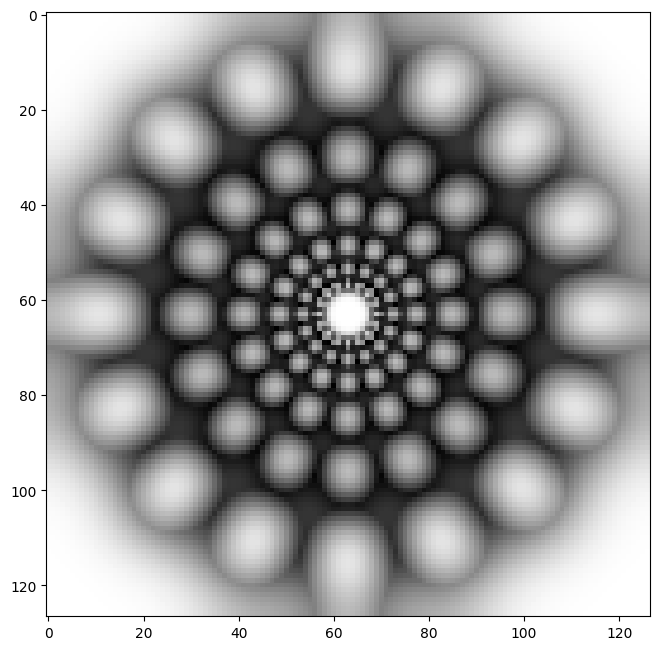

In [8]:
# Visualization Gabor filter
# figure size
org_fz = plt.rcParams['figure.figsize']
org_dpi = plt.rcParams['figure.dpi']
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

# generate filters
K = 8
S = 6
filters = genGaborFilters(K=K, S=S)

# display filters
for i in range(S*K):
    plt.subplot(S, K, i+1)
    plt.imshow(filters[i], 'gray')
plt.show()

# display filters with certain orientation
orientation = 0
plt.subplot(1, 2, 1)
plt.imshow(filters[orientation], 'gray')
plt.subplot(1, 2, 2)
plt.imshow(filters[K*(S-1)+orientation], 'gray')
plt.show()

# display Fourior transform of Gabor filter
half_peaks = None
for i in range(S*K):
    f = np.fft.fft2(filters[i])
    fshift = np.fft.fftshift(f)
    mag = np.abs(fshift)
    half_peak = np.abs(mag - np.max(mag)/2)
    if half_peaks is None:
        half_peaks = half_peak/np.max(mag)
    else:
        half_peaks += half_peak/np.max(mag)
    plt.subplot(S, K, i+1)
    plt.imshow(mag, 'gray')
plt.show()

# display half peak
plt.imshow(half_peaks, 'gray')
plt.show()

# reset figure size
plt.rcParams['figure.figsize'] = org_fz
plt.rcParams['figure.dpi'] = org_dpi